At fetch, we are monitoring the number of the scanned receipts to our app on a daily base as one of our KPIs. From business standpoint, we sometimes need to predict the possible number of the scanned receipts for a given future month.

The following link provides the number of the observed scanned receipts each day for the year 2021. Based on this prior knowledge, please develop an algorithm which can predict the approximate number of the scanned receipts for each month of 2022.

In [ ]:
!pip install streamlit

In [1]:
from google.colab import files
from google.colab import drive
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.autograd import Variable
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd

path = '/content/drive'
drive.mount(path)
fetch_data_path = "/content/drive/My Drive/Interview/fetch/data_daily.csv"

Mounted at /content/drive


In [19]:
raw = pd.read_csv(fetch_data_path)
raw['# Date'] = pd.to_datetime(raw['# Date'])
Y_min = raw['Receipt_Count'].values.astype(float).min()
Y_max = raw['Receipt_Count'].values.astype(float).max()
Y = raw['Receipt_Count'].values.astype(float)
Y = Y.reshape(-1, 1)

def normalize_column(column):
  normalized = (column - column.min()) / (column.max() - column.min())
  return torch.tensor(normalized.values, dtype=torch.float32)
Y = normalize_column(raw['Receipt_Count'])


In [20]:
#Create X sequences from number of receipts
def create_sequences(data, seq_length):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])
        targets.append(data[i+1:i+seq_length+1])
    return torch.stack(sequences), torch.stack(targets)

seq_length = 14
sequences, targets = create_sequences(Y, seq_length)

#Loading data as tensor
sequences = torch.tensor(sequences, dtype=torch.float32)
targets = torch.tensor(targets, dtype=torch.float32)
dataset = TensorDataset(sequences, targets)

#Setting train_size, test_size, batch_size
train_size = int(0.8 * sequences.shape[0])
test_size = sequences.shape[0] - train_size
batch_size = 32

#Load data into dataloader
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

<ipython-input-20-86d19236117b>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequences = torch.tensor(sequences, dtype=torch.float32)
<ipython-input-20-86d19236117b>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets, dtype=torch.float32)


In [21]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size)
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, input):
        x, _ = self.lstm(input)
        x = self.linear(x)
        return x

In [22]:
input_size = seq_length
hidden_size = 64
num_layers = 2
output_size = seq_length
model = LSTM(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [23]:
# Set the model to training mode
model.train()
num_epochs = 500
for epoch in range(num_epochs):
    total_loss = 0
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    average_loss = total_loss / len(train_loader)
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss:.4f}')


Epoch [10/500], Loss: 0.0206
Epoch [20/500], Loss: 0.0041
Epoch [30/500], Loss: 0.0037
Epoch [40/500], Loss: 0.0036
Epoch [50/500], Loss: 0.0035
Epoch [60/500], Loss: 0.0034
Epoch [70/500], Loss: 0.0033
Epoch [80/500], Loss: 0.0032
Epoch [90/500], Loss: 0.0032
Epoch [100/500], Loss: 0.0031
Epoch [110/500], Loss: 0.0030
Epoch [120/500], Loss: 0.0030
Epoch [130/500], Loss: 0.0029
Epoch [140/500], Loss: 0.0028
Epoch [150/500], Loss: 0.0027
Epoch [160/500], Loss: 0.0025
Epoch [170/500], Loss: 0.0024
Epoch [180/500], Loss: 0.0022
Epoch [190/500], Loss: 0.0020
Epoch [200/500], Loss: 0.0019
Epoch [210/500], Loss: 0.0017
Epoch [220/500], Loss: 0.0016
Epoch [230/500], Loss: 0.0015
Epoch [240/500], Loss: 0.0013
Epoch [250/500], Loss: 0.0012
Epoch [260/500], Loss: 0.0011
Epoch [270/500], Loss: 0.0010
Epoch [280/500], Loss: 0.0009
Epoch [290/500], Loss: 0.0009
Epoch [300/500], Loss: 0.0007
Epoch [310/500], Loss: 0.0007
Epoch [320/500], Loss: 0.0006
Epoch [330/500], Loss: 0.0006
Epoch [340/500], Lo

In [24]:
# Set the model to evaluation mode
model.eval()
total_loss = 0
with torch.no_grad():
    for batch_x, batch_y in test_loader:
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        total_loss += loss.item()

average_loss = total_loss / len(test_loader)
print(f'Evaluation Loss: {average_loss:.4f}')

def revert(x):
  return Y_min+x*(Y_max-Y_min)

Evaluation Loss: 0.0004


In [25]:
#Create prediction for next year 2022
Y_new = Y.detach()
for j in range(365):
    with torch.no_grad():
        prediction = model(Y_new[-seq_length:].view(-1,seq_length))
    prediction = torch.tensor(prediction[0,-1].item()).view(1)
    # Append the predicted value to the tensor array
    Y_new = torch.cat((Y_new, prediction))
output = revert(Y_new)

output2 = output.detach()


In [26]:
#Evaluate the model using 2021 data
Y_val = []
for k in range(365-seq_length):
    input = Y[k:k+seq_length].view(-1,seq_length)
    Y_val.append(revert(model(input)[0,-1].item()))
Y_val = [0] * seq_length + Y_val
y2=Y_val
y2_tensor = torch.tensor(y2)
output2[:365] = y2_tensor

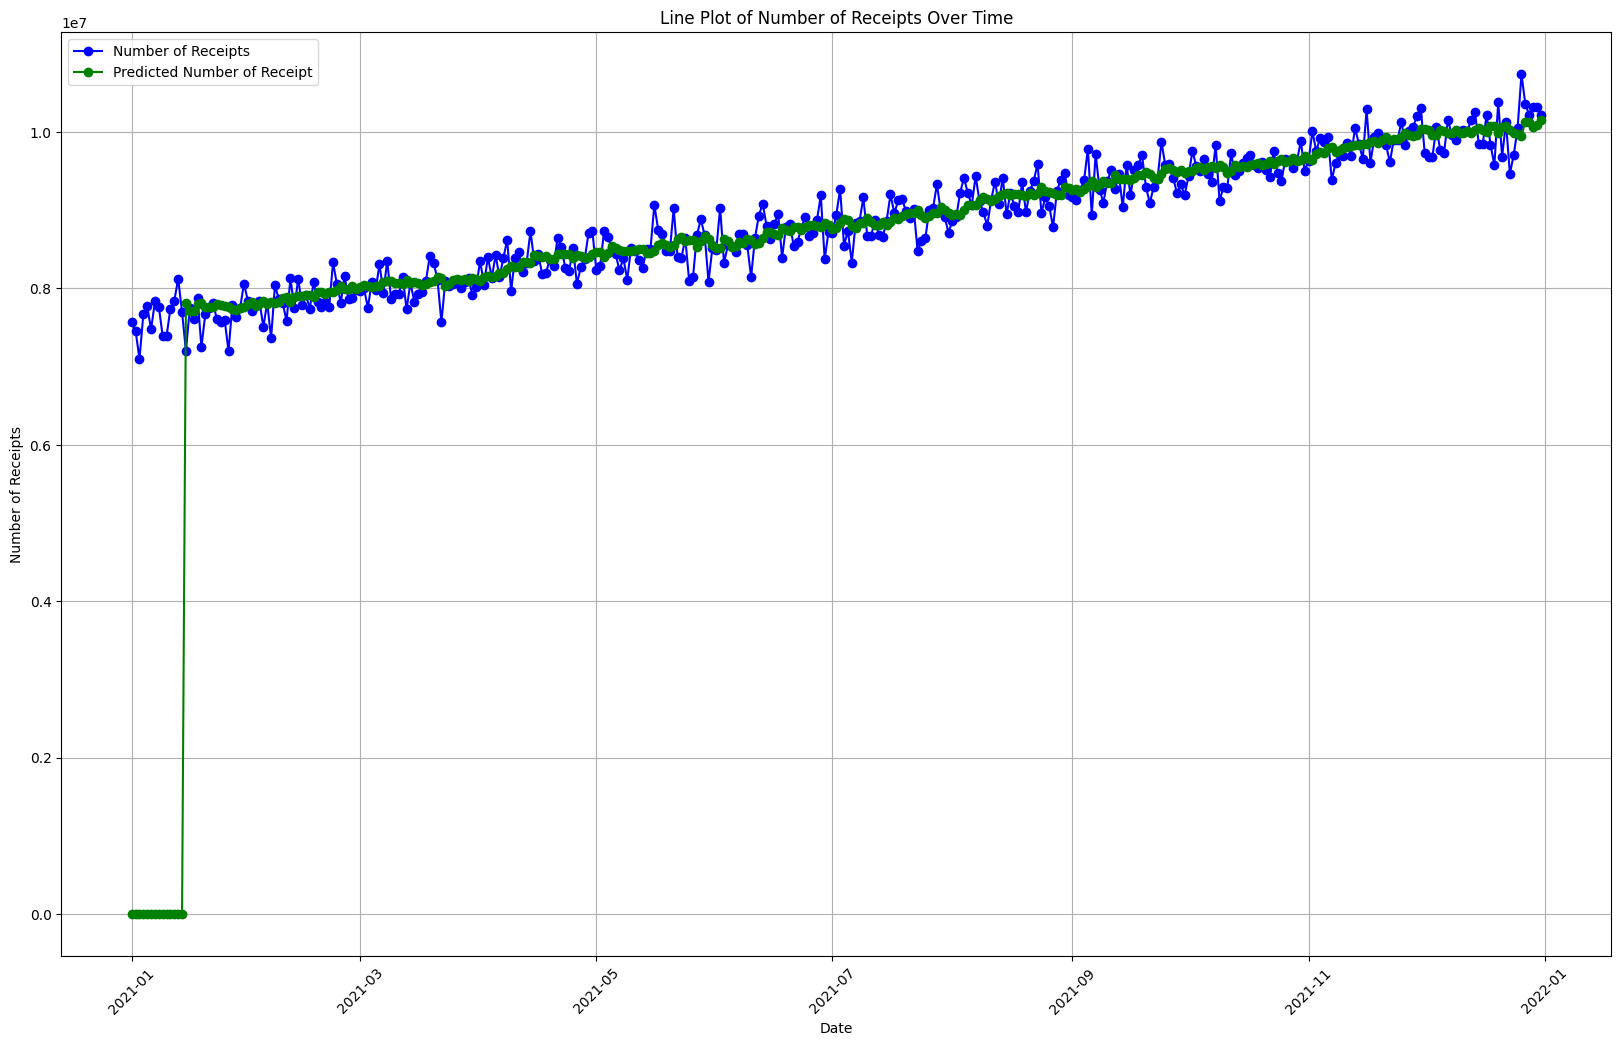

In [27]:
#Plotting real values versus predicted values for 2021 for validation:

import matplotlib.pyplot as plt
x = raw['# Date']
y = raw['Receipt_Count']

# Create a scatter plot
plt.figure(figsize=(20, 12))
plt.plot(x, y, label='Number of Receipts', color='blue', marker='o', linestyle='-')
plt.plot(x, y2, label='Predicted Number of Receipt', color='green', marker='o', linestyle='-')
plt.xlabel('Date')
plt.ylabel('Number of Receipts')
plt.title('Line Plot of Number of Receipts Over Time')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

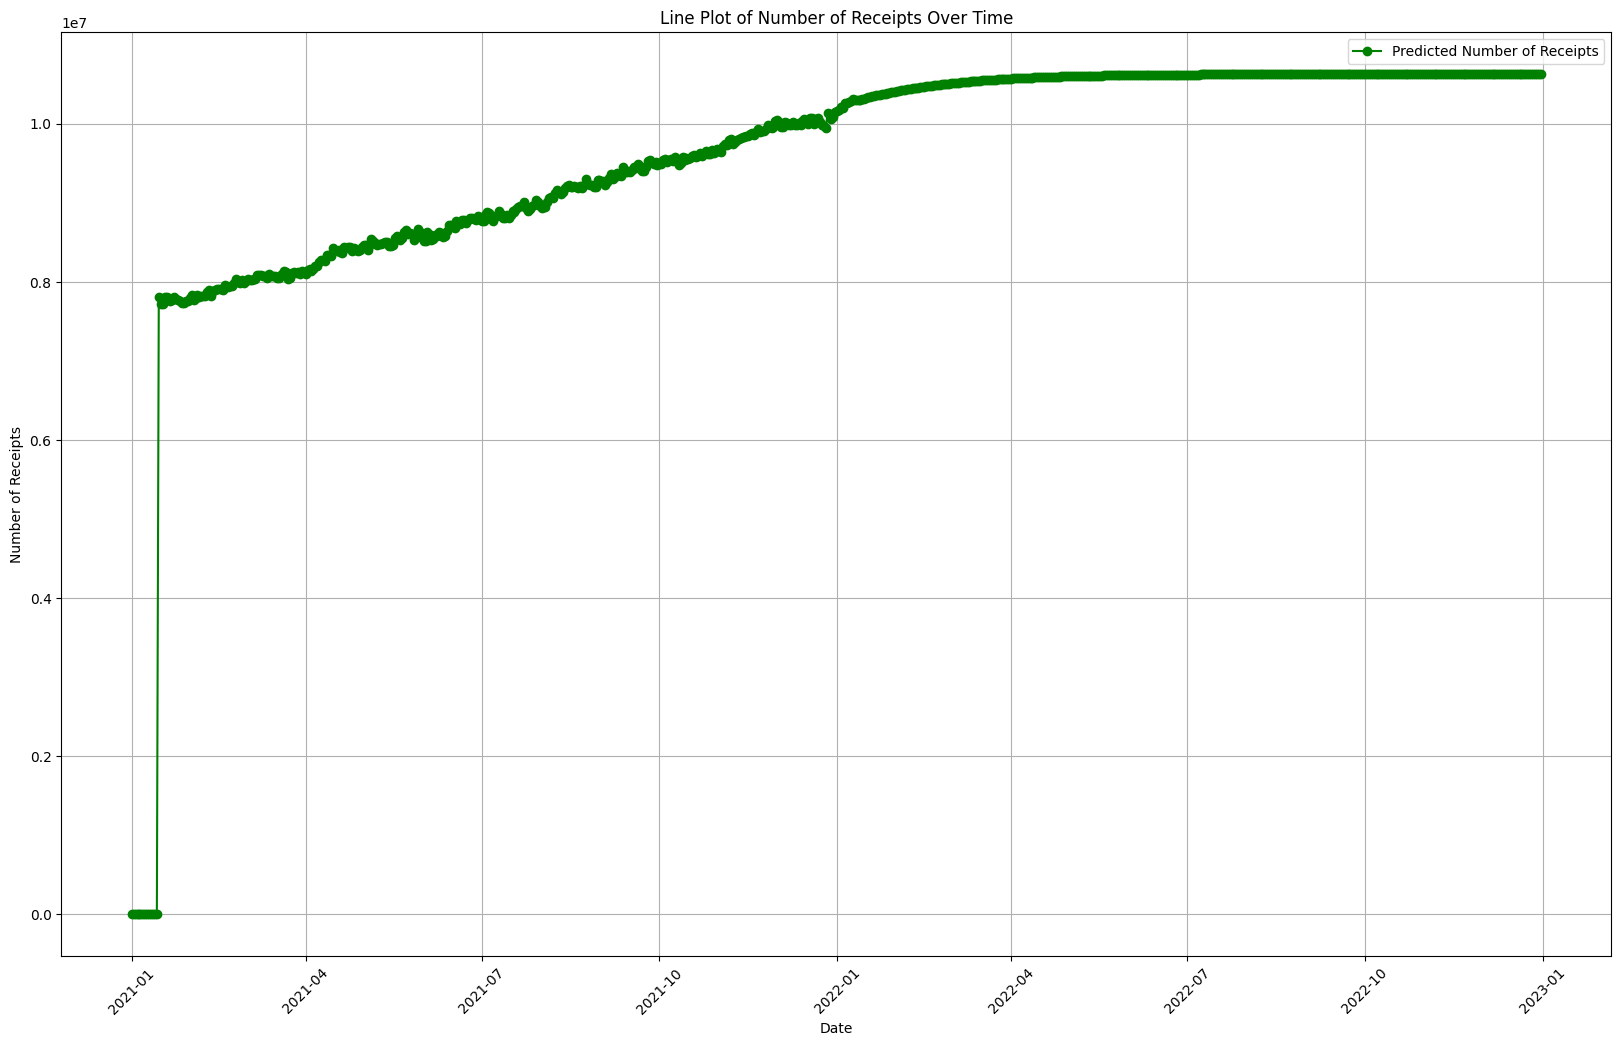

In [28]:
#Plotting all predicted values from 2021 to 2022


start_date_2021 = pd.to_datetime("2021-01-01")  # Start date for 2022
end_date_2022 = pd.to_datetime("2022-12-31")    # End date for 2022
date_range_2021_2022 = pd.date_range(start_date_2021, end_date_2022, freq='D')
x_new= pd.DataFrame({'# Date': date_range_2021_2022})

plt.figure(figsize=(20, 12))
plt.plot(x_new, output2, label='Predicted Number of Receipts', color='green', marker='o', linestyle='-')
plt.xlabel('Date')
plt.ylabel('Number of Receipts')
plt.title('Line Plot of Number of Receipts Over Time')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

In [32]:
#Visualize using streamlit
import streamlit as st
st.pyplot(plt)

2023-10-21 04:34:14.322 
  command:

    streamlit run /usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py [ARGUMENTS]


DeltaGenerator()

In [37]:
st.write('Hello, *World!* :sunglasses:')